In [1]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
from sklearn.manifold import TSNE

# Auto-encoders 101
In this notebook you will implement a simple auto-encoder (AE). We assume that you are already familiar with the basics of neural networks. If not, please refer to *lab1*. We'll start by defining a simple AE similar to the one used for the finetuning step by [Geoffrey Hinton and Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). We'll experiment with the AE setup and try to run it on the MNIST dataset. There has been a wide variety of research into the field of auto-encoders and the technique that you're about to learn is very simple compared to recent advances (e.g. [the Ladder network](https://arxiv.org/abs/1507.02672) and [VAEs](https://arxiv.org/abs/1312.6114)). However, the basic idea stays the same.

AEs are used within unsupervised learning, in which you do not have a target $y$. Instead it *encodes* an input $x$ into a latent state $z$ and decodes $z$ into a reconstruction $\hat{x}$. This way the parameters of the network can be optimized w.r.t. the difference between $x$ and $\hat{x}$. Depending on the input distribution, the difference can be measured in various ways, e.g. mean squared error (MSE). In many applications the auto-encoder will find a highly non-linear internal state of each data point corresponding to a strong feature. So if we are to model the MNIST dataset, one could expect that the internal state would correspond to a digit and/or the shape.

*The exercises are found at the bottom of the notebook*

## MNIST
First let's load the MNIST dataset and plot a few examples. We only load a limited amount of number classes, so that we can speed up training.

In [2]:
from sklearn.utils import shuffle

# To speed up training we'll only work on a subset of the data containing only the numbers 0, 1.
data = np.load('../lab1/mnist.npz')
num_classes = 10
idxs_train = []
idxs_valid = []
idxs_test = []
nchannels,rows,cols = 1,28,28
for i in range(num_classes):
    idxs_train += np.where(data['y_train'] == i)[0].tolist()
    idxs_valid += np.where(data['y_valid'] == i)[0].tolist()
    idxs_test += np.where(data['y_test'] == i)[0].tolist()

x_train = data['X_train'][idxs_train].astype('float32')

#Added to make right shape#
#x_train = x_train.reshape((-1,nchannels,rows,cols))
###########################
targets_train = data['y_train'][idxs_train].astype('int32') # Since this is unsupervised, the targets are only used for validation.
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)


x_valid = data['X_valid'][idxs_valid].astype('float32')
#Added to make right shape#
#x_valid = x_valid.reshape((-1,nchannels,rows,cols))
###########################
targets_valid = data['y_valid'][idxs_valid].astype('int32')

x_test = data['X_test'][idxs_test].astype('float32')
#Added to make right shape#
#x_test = x_test.reshape((-1,nchannels,rows,cols))
###########################
targets_test = data['y_test'][idxs_test].astype('int32')



print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)

training set dim(50000, 784).
validation set dim(10000, 784).
test set dim(10000, 784).


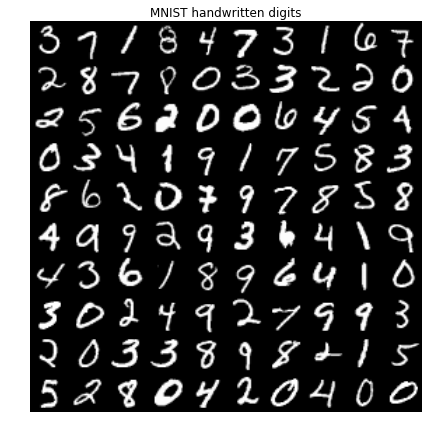

In [3]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')

### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. There are multiple ways of implementing an AE and you will soon experiment with the different variations. We initialize the AE with 1 hidden layer in the encoder and decoder using relu units as non-linearity. The latent layer has a dimensionality of 2. Since the input $x$ is pixel intensities that are normalized between 0 and 1, we use the properties of the sigmoid non-linearity to model the reconstruction.

In [10]:
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.nonlinearities import rectify, sigmoid

#define the model
num_features = x_train.shape[1]

l_in = InputLayer(shape=(None,num_features))

l_enc_1 = DenseLayer(incoming=l_in, num_units=254, nonlinearity=rectify)
l_enc_2 = DenseLayer(incoming=l_enc_1, num_units=512, nonlinearity=rectify)
l_enc_3 = DenseLayer(incoming=l_enc_2, num_units=784, nonlinearity=rectify)

l_z = DenseLayer(incoming=l_enc_3, num_units=100, nonlinearity=sigmoid) # None indicates a linear output.

l_dec_1 = DenseLayer(l_z, num_units=784, nonlinearity=rectify)
l_dec_2 = DenseLayer(l_dec_1, num_units=512, nonlinearity=rectify)
l_dec_3 = DenseLayer(incoming=l_dec_2, num_units=254, nonlinearity=rectify)

l_out = DenseLayer(l_dec_3, num_units=num_features, nonlinearity=sigmoid) # iid pixel intensities between 0 and 1.

Following we define the Theano functions for training and evaluation.

In [11]:
from lasagne.objectives import squared_error, binary_crossentropy

sym_x = T.matrix('sym_x') # a symbolic variable taking on the value of a input batch.

# Get network output
train_out, train_z = lasagne.layers.get_output([l_out, l_z], sym_x, deterministic=False)
eval_out, eval_z = lasagne.layers.get_output([l_out, l_z], sym_x, deterministic=True)


# Get list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

##TRYING A DIFFERENT COST FUNCTION
#cost = squared_error(train_out, sym_x).mean()
cost = binary_crossentropy(train_out,sym_x).mean()


eval_cost = binary_crossentropy(eval_out, sym_x).mean()

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)


# Set the update function for parameters 
# you might want to experiment with more advanced update schemes like adam, rmsprob, adadelta etc.
#updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=0.25)
updates = lasagne.updates.adam(all_grads, all_params)


f_eval = theano.function([sym_x],
                     [eval_cost, eval_out, eval_z], on_unused_input='warn')

f_train = theano.function([sym_x],
                          [cost, train_out, train_z],
                          updates=updates, on_unused_input='warn')

In the training loop we sample each batch and evaluate the error, latent space and reconstructions every epoch.

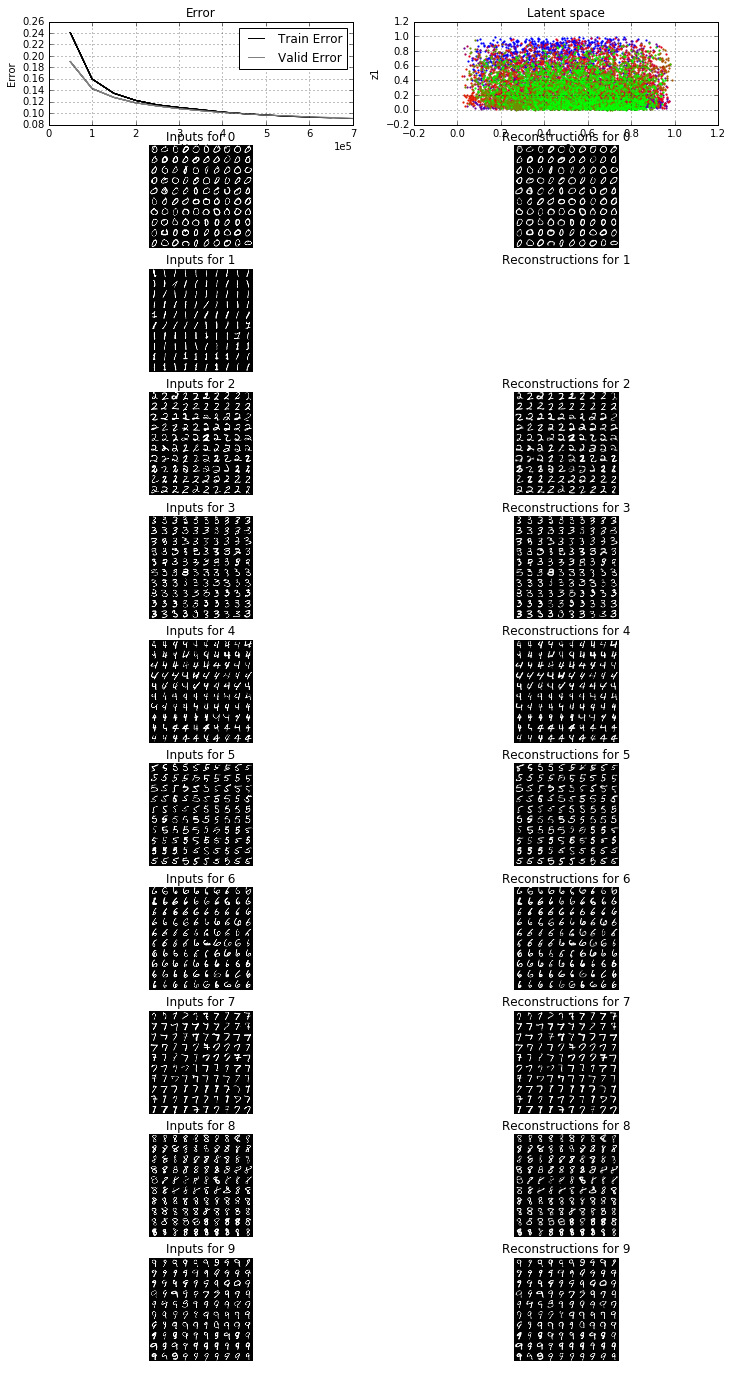

In [12]:
batch_size = 100
num_epochs = 100
learning_rate = 0.1
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size
updates = []

train_loss = []
valid_loss = []
cur_loss = 0
plt.figure(figsize=(12, 24))
print("Starting training")

try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = []
        for i in range(num_batches_train):
            idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)    
            x_batch = x_train[idxs]
            batch_loss, train_out, train_z = f_train(x_batch) #this will do the complete backprob pass
            cur_loss += [batch_loss]
        train_loss += [np.mean(cur_loss)]
        updates += [batch_size*num_batches_train*(epoch+1)]

        eval_loss, eval_out, eval_z = f_eval(x_valid)
        valid_loss += [eval_loss]

        if epoch == 0:
            continue

        # Plotting
        plt.subplot(num_classes+1,2,1)
        plt.title('Error')
        plt.legend(['Train Error', 'Valid Error'])
        plt.xlabel('Updates'), plt.ylabel('Error')
        plt.plot(updates, train_loss, color="black")
        plt.plot(updates, valid_loss, color="grey")
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.grid('on')

        plt.subplot(num_classes+1,2,2)
        plt.cla()
        plt.title('Latent space')
        plt.xlabel('z0'), plt.ylabel('z1')
        color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
        for i in range(num_classes):
            clr = next(color)
            plt.scatter(eval_z[targets_valid==i, 0], eval_z[targets_valid==i, 1], c=clr, s=5., lw=0, marker='o', )
        plt.grid('on')
        
        c=0
        for k in range(3, 3 + num_classes*2, 2):
            plt.subplot(num_classes+1,2,k)
            plt.cla()
            plt.title('Inputs for %i' % c)
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==c][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            plt.subplot(num_classes+1,2,k+1)
            plt.cla()
            plt.title('Reconstructions for %i' % c)
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = eval_out[targets_valid==c][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            c+=1
      
        
        plt.savefig("out.png")
        display(Image(filename="out.png"))
        clear_output(wait=True)
        
except KeyboardInterrupt:
    pass
    

In [13]:
model = TSNE(n_components=2,random_state=0)
xplot = model.fit_transform(eval_z)

[ 0.  0.  1.  1.]
[ 0.21960784  0.          0.78039216  1.        ]
[ 0.43921569  0.          0.56078431  1.        ]
[ 0.66666667  0.          0.33333333  1.        ]
[ 0.88627451  0.          0.11372549  1.        ]
[ 0.88627451  0.11372549  0.          1.        ]
[ 0.66666667  0.33333333  0.          1.        ]
[ 0.43921569  0.56078431  0.          1.        ]
[ 0.21960784  0.78039216  0.          1.        ]
[ 0.  1.  0.  1.]


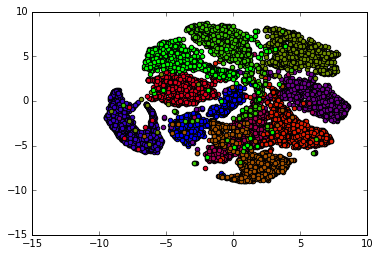

In [14]:

slices = []
for i in range(num_classes):
    slices.append(len(eval_z[targets_valid==i,0]))

color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
counter = 0
for i,number in enumerate(slices):
    clr = next(color)
    print(clr)
    for data in xplot[counter:number+counter]:
        plt.scatter(data[0],data[1],c=clr)
        
    counter += number

plt.savefig("t-sne-latent_20_all_digits.png")
plt.show()

### Exercise 1 - Analyzing the AE
1. The above implementation of an AE is very simple.
    - *Experiment with the number of layers and non-linearities in order to improve the reconstructions.*
    - *What happens with the network when we change the non-linearities in the latent layer (e.g. sigmoid)?*
    - *Try to increase the number of digit classes in the training set and analyze the results.*
    - *Test different optimization algorithms and decide whether you should use regularizers*.
       
2. Currently we optimize w.r.t. mean squared error. 
    - *Find another error function that could fit this problem.* 
    - *Evaluate whether the error function is a better choice and explain your findings.*

3. Complexity of the bottleneck.
    - *Increase the number of units in the latent layer and train.*
    - *Visualize by using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).*

## Answer
1)
* The reconstructions all look much alike, there is some of the characters that are reconstructed into a wrong character.

* Changing the latent layer to a sigmoid 
* Increasing the number of digit classes takes longer. It looks like it is creating a generalization of the digits. Some of the digits when being reconstructed i generated as a wrong class.

* Testing different optimization algorithms
adam the reconstruction is mush better compared to the SGD optimization, The SGD made all the digits look the same but with this optimizer there is a larger reconstruction space.
RMSprop - This is note working very well - or i might have a wrong learning rate set
adadelta - This looks to be doing abit better then SGD but not as well as the adam.

2) Used binary crossentropy, im not sure it was a better choice


3) Increasing the number of units in the latent layer greatly improved the reconstruction



### Exercise 2 - Adding classification (for the ambitious)
The above training has been performed unsupervised. Now let us assume that we only have a fraction of labeled data points from each class (implemented below). As we know, semi-supervised learning can be utilized by combining unsupervised and supervised learning. Now you must analyze whether a trained AE from the above exercise can aid a classifier.

1. Build a simple classifier (like the ones from lab1) where you:
    - *Train on the labeled dataset and evaluate the results.*
    * The result after training on was bad
2. Build a second classifier and train on the latent output $z$ of the AE.
3. Build a third classifier and train on the reconstructions of the AE.
4. Evaluate the classifiers against each other and implement a model that improves the classification by combining the input, latent output and reconstruction.

labeled training set dim(100, 784).


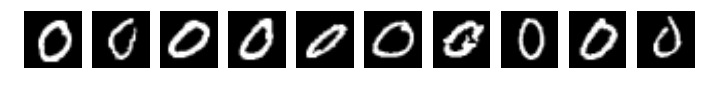

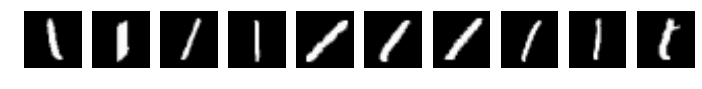

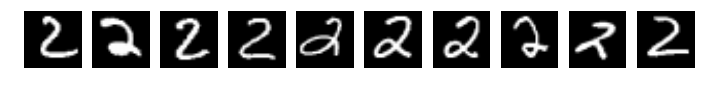

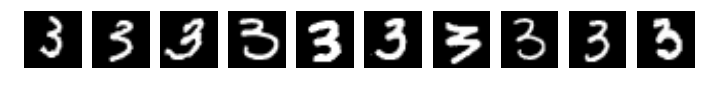

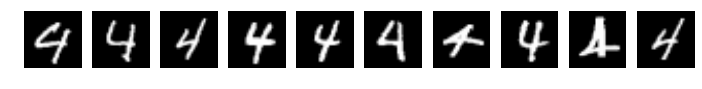

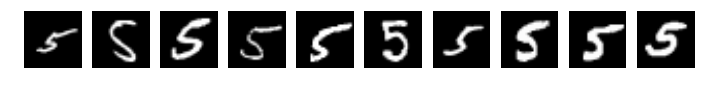

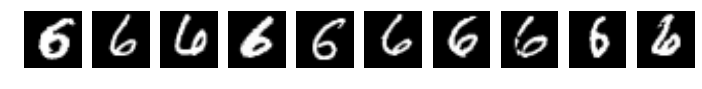

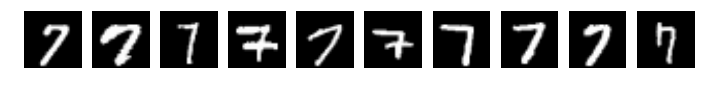

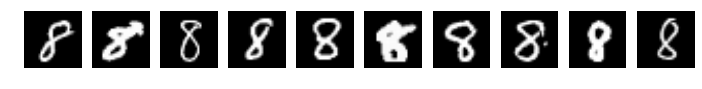

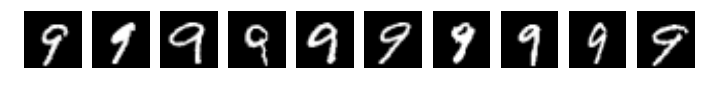

In [15]:
# Generate a subset of labeled data points

num_labeled = 10 # You decide on the size of the fraction...

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

idxs_train_l = []
for i in range(num_classes):
    idxs = np.where(targets_train == i)[0]
    idxs_train_l += np.random.choice(idxs, size=num_labeled).tolist()

x_train_l = x_train[idxs_train_l]
targets_train_l = targets_train[idxs_train_l]
print("labeled training set dim(%i, %i)." % x_train_l.shape)


x1 = 0
for r in range(10):
    plt.figure(figsize=(12, 7))
    for i in range(num_classes):
        x = i + x1
        im = x_train_l[x].reshape((28, 28))
        plt.subplot(1, num_classes, i + 1)
        plt.imshow(im, cmap='gray')
        plt.axis('off')
    x1 += 10
    

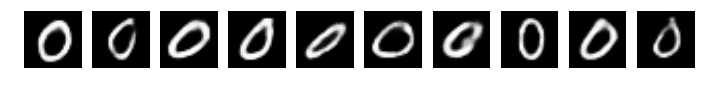

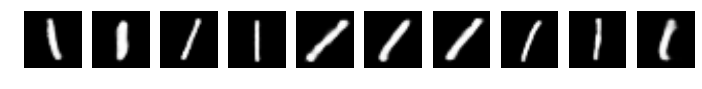

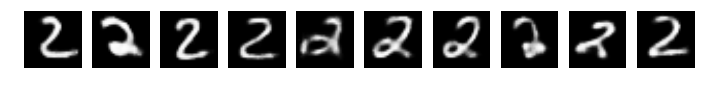

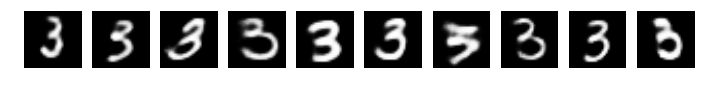

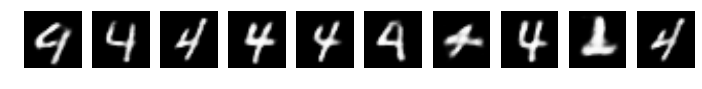

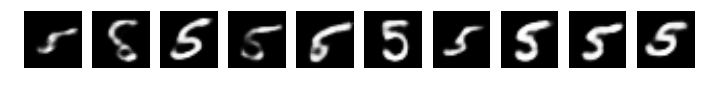

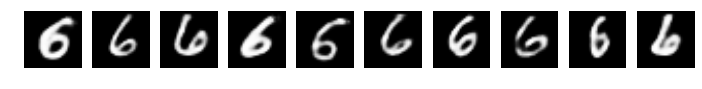

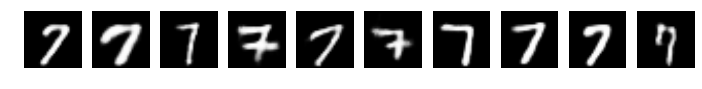

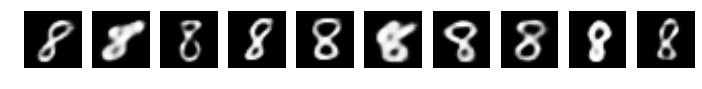

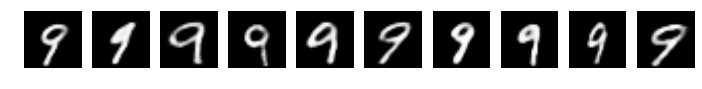

In [16]:
ae_cost,ae_train,ae_z = f_eval(x_train_l)


    
x1 = 0
for r in range(10):
    plt.figure(figsize=(12, 7))
    for i in range(10):
        x = i + x1
        im = ae_train[x].reshape((28, 28))
        plt.subplot(1, num_classes, i + 1)
        plt.imshow(im, cmap='gray')
        plt.axis('off')
    x1 += 10

In [17]:
ae_z.shape

(100, 100)

In [18]:
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.nonlinearities import rectify, sigmoid, softmax
from lasagne.regularization import regularize_layer_params_weighted , l2
#define the model
num_class = 10
num_features = 100

################# Added code #######################

l_in = InputLayer(shape=(None,num_features))
l_hid_1 = DenseLayer(incoming=l_in, num_units=100, nonlinearity=rectify)
l_hid_2 = DenseLayer(incoming=l_hid_1, num_units=256, nonlinearity=rectify)
l_hid_3 = DenseLayer(incoming=l_hid_2, num_units=256, nonlinearity=rectify)
l_out = DenseLayer(incoming=l_hid_3, num_units=num_class, nonlinearity=softmax)


###################################################

In [19]:
sym_x = T.matrix('sym_x') # a symbolic variable taking on the value of a input batch.
sym_t = T.ivector('sym_t') # a symbolic variable taking on the value of the target batch.

# Get network output
train_out = lasagne.layers.get_output(l_out, sym_x, deterministic=False)
eval_out_1 = lasagne.layers.get_output(l_out, sym_x, deterministic=True)


# Get list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)


cost = T.nnet.categorical_crossentropy(train_out+1e-8, sym_t).mean() 
# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)


# Set the update function for parameters 
# you might wan't to experiment with more advanded update schemes like rmsprob, adadelta etc.
#updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=0.1)
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=3*1e-4)


f_eval_ae = theano.function([sym_x],
                     eval_out_1, on_unused_input='warn')

f_train_ae = theano.function([sym_x, sym_t],
                          [cost],
                          updates=updates, on_unused_input='warn')

In [30]:
num_of_epochs = 1000
for i in range(num_of_epochs):
    ae_cost,ae_train,ae_z = f_eval(x_train_l)
    loss = f_train_ae(ae_z,targets_train_l)




In [31]:
test_cost,test_out,test_z = f_eval(x_test)
test_prediction = f_eval_ae(test_z)

In [34]:
counter = 0
for i in range(10000):
    if np.argmax(test_prediction[i,:]) == targets_test[i]:
        counter += 1
print(counter/10000.0, "Test accuray with z as input for classification")

0.7917 Test accuray with z as input for classification


In [33]:
t_c,t_out,t_z = f_eval(x_test[1,:])
plt.figure(figsize=(12, 7))

im = x_test[0].reshape((28, 28))
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

TypeError: ('Bad input argument to theano function with name "<ipython-input-11-1b043f28c495>:31" at index 0 (0-based)', 'Wrong number of dimensions: expected 2, got 1 with shape (784,).')

In [25]:
targets_test.shape

(10000,)

In [26]:
from confusionmatrix import ConfusionMatrix
batch_size = 100
num_epochs = 10
learning_rate = 0.1
num_samples_train = x_train_l.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
for epoch in range(num_epochs):
    #Forward->Backprob->Update params
    cur_loss = 0
    for i in range(num_batches_train):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train_l[idx]
        target_batch = targets_train_l[idx]    
        batch_loss = f_train(x_batch,target_batch) #this will do the complete backprob pass
        cur_loss += batch_loss[0]
    loss += [cur_loss/batch_size] 
    
    confusion_valid = ConfusionMatrix(num_classes)
    confusion_train = ConfusionMatrix(num_classes)

    for i in range(num_batches_train):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train_l[idx]
        targets_batch = targets_train_l[idx]
        net_out = f_eval(x_batch)   
        preds = np.argmax(net_out, axis=-1) 
        confusion_train.batch_add(targets_batch, preds)

    confusion_valid = ConfusionMatrix(num_classes)
    for i in range(num_batches_valid):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_valid[idx]
        targets_batch = targets_valid[idx]
        net_out = f_eval(x_batch)   
        preds = np.argmax(net_out, axis=-1) 
        
        confusion_valid.batch_add(targets_batch, preds)
    
    train_acc_cur = confusion_train.accuracy()
    valid_acc_cur = confusion_valid.accuracy()

    train_acc += [train_acc_cur]
    valid_acc += [valid_acc_cur]
    print("Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
    % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur))

TypeError: ('Bad input argument to theano function with name "<ipython-input-11-1b043f28c495>:35" at index 1 (0-based)', 'Wrong number of dimensions: expected 2, got 1 with shape (100,).')

(<matplotlib.text.Text at 0x7fce0a1a7b50>,
 <matplotlib.text.Text at 0x7fce0b5c1190>)

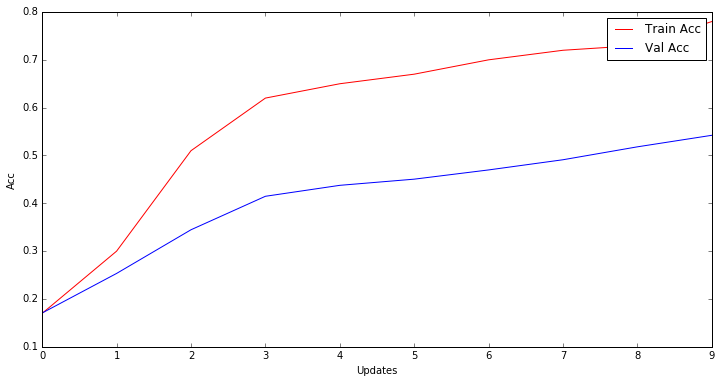

In [166]:
epoch = np.arange(len(train_acc))
plt.figure(figsize=(12,6))
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Updates'), plt.ylabel('Acc')

In [27]:
len(eval_z)

10000

In [28]:
s = 0
for i in range(num_classes):
    s += len(eval_out[targets_valid==i,0])
    print(len(eval_out[targets_valid==i,0]))
    
print(s)

991
1064
990
1030
983
915
967
1090
1009
961
10000


In [35]:
import theano